In [4]:
# Importing Libraries

!pip install keras==2.2.4
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers, models
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from prettytable import PrettyTable


import warnings
warnings.filterwarnings("ignore")
print(" Libraries Imported Successfully")

 Libraries Imported Successfully


In [5]:
# returns the length of the input data

class Length(layers.Layer):
    def call(self, inputs, **kwargs): 
        return K.sqrt(K.sum(K.square(inputs), -1)) 
 
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

print("Length function Created")

Length function Created


In [6]:
# masking layer
class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list: 
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            x = inputs
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked
    
 # Function to compute the ouput shape of the model
    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])
print("Mask function and compute_ouput_shape created")

Mask function and compute_ouput_shape created


In [7]:
# Squash Function
# The length of the activity vector is fed into a non-linear transformation called the squashing function
# the length of output vector becomes less than 1 because it is used to represent probability

def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors

print("Squash function created")

Squash function created


In [8]:
# Capsule Layer 
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
 # first we need to build this function witn input shape to use this capsule layer architecture
    def build(self, input_shape):
        #assert len(input_shape) >= 3,
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]
 
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')
 
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True
 
    def call(self, inputs, training=None):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
 
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])
 
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
 
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
 
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
 
 
            if i != self.num_routing - 1:
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])
 # Computes the ouput shape
    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])
    
print("Capsule layer architecture")

Capsule layer architecture


In [9]:
# Primary Capsule function
# primary capsules are fed into higher layer capsules

def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)
print("Primary capsule function created")

Primary capsule function created


In [10]:
# Model : Capsule neural network
from keras import backend as K
def CapsNet(input_shape, n_class, num_routing):
    x = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)
    out_caps = Length(name='out_caps')(digitcaps)
 
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(width*breadth*3, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[width, breadth, 3], name='out_recon')(x_recon)
 
    return models.Model([x, y], [out_caps, x_recon])

print("Capsule Network model created")

Capsule Network model created


In [11]:
# Margin loss function
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
 
    return K.mean(K.sum(L, 1))
width, breadth = 32, 32

print("Margin loss function created")

Margin loss function created


In [13]:
print("                Proposed Model: Capsule Neural Network Model        ")

# CapsNet: Model compilation
model = CapsNet(input_shape=[width, breadth, 3],
                n_class=5,
                num_routing=3)
model.summary()

try:
    print(plot_model(model, to_file='model.png', show_shapes=True))
except Exception as e:
    print('No fancy plot {}'.format(e))

print("Model Compilation")

                Proposed Model: Capsule Neural Network Model        
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 256)  62464       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2048, 8)      0           conv2d_2[0][0]                   
________________________________________

In [14]:
# make data: train and test eye images
# If it is 1_left, it seems that it is a picture of the left eye of a person with patientID = 1.

#trainCSV = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
trainCSV = pd.read_csv('../input/trainlabels/trainLabels.csv')
trainCSV['PatientId'] = trainCSV['image'].map(lambda x: x.split('_')[0])
trainCSV['imagePath'] = trainCSV['image'].map(lambda x: os.path.join('../input/dataset/dataset/','{}.jpeg'.format(x)))
#trainCSV['imagePath'] = trainCSV['image'].map(lambda x: os.path.join('../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped','{}.jpeg'.format(x)))
trainCSV['exists'] = trainCSV['imagePath'].map(os.path.exists)
print(trainCSV['exists'].sum(), 'images found of', trainCSV.shape[0], 'total')
trainCSV['leftorright'] = trainCSV['image'].map(lambda x: 'left' if x.split('_')[-1]=='left' else 'right')
trainCSV['label'] = trainCSV['level'].map(lambda x: to_categorical(x, 5))
trainCSV.dropna(inplace = True)
trainCSV = trainCSV[trainCSV['exists']]
print('Selected Dataset Shape: ',trainCSV.shape)
trainCSV.sample(5)

8408 images found of 35126 total
Selected Dataset Shape:  (8408, 7)


,image,level,PatientId,imagePath,exists,leftorright,label
11567,14522_right,1,14522,../input/dataset/dataset/14522_right.jpeg,True,right,"[0.0, 1.0, 0.0, 0.0, 0.0]"
12734,15973_left,0,15973,../input/dataset/dataset/15973_left.jpeg,True,left,"[1.0, 0.0, 0.0, 0.0, 0.0]"
10552,13275_left,0,13275,../input/dataset/dataset/13275_left.jpeg,True,left,"[1.0, 0.0, 0.0, 0.0, 0.0]"
14451,18126_right,3,18126,../input/dataset/dataset/18126_right.jpeg,True,right,"[0.0, 0.0, 0.0, 1.0, 0.0]"
14072,17675_left,0,17675,../input/dataset/dataset/17675_left.jpeg,True,left,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [15]:
# Print train dataset

print(trainCSV.shape)
#trainCSV = trainCSV[:1500]
print(trainCSV)

(8408, 7)
             image  level PatientId  \
0          10_left      0        10   
1         10_right      0        10   
2          13_left      0        13   
3         13_right      0        13   
4          15_left      1        15   
...            ...    ...       ...   
15573  19493_right      1     19493   
15574   19494_left      0     19494   
15575  19494_right      0     19494   
15576   19498_left      0     19498   
15577  19498_right      0     19498   

                                       imagePath  exists leftorright  \
0          ../input/dataset/dataset/10_left.jpeg    True        left   
1         ../input/dataset/dataset/10_right.jpeg    True       right   
2          ../input/dataset/dataset/13_left.jpeg    True        left   
3         ../input/dataset/dataset/13_right.jpeg    True       right   
4          ../input/dataset/dataset/15_left.jpeg    True        left   
...                                          ...     ...         ...   
15573  ../input/d

Distribution of Severity of each class - 0,1,2,3,4


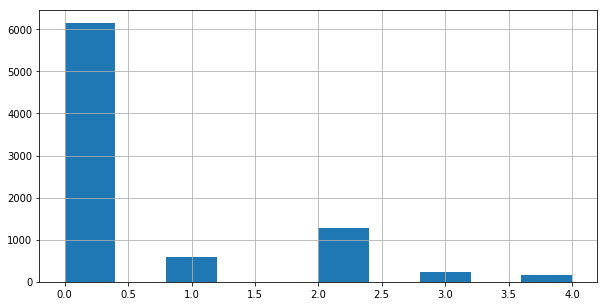

In [16]:
# Examine the distribution of severity
print("Distribution of Severity of each class - 0,1,2,3,4")
trainCSV['level'].hist(figsize = (10, 5))

In [17]:
# Importing libraries required to transform Image to Array
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import time
import sys

In [18]:
# Function to transform Retinal images to Arrays
def transformImagetoArray(imagePathsList, width=480, breadth=480):
    startTime = time.time()
    imagesArrayList = []
    for imagePath in imagePathsList:
        image = np.array(Image.open(imagePath).resize((width, breadth)), np.float).reshape(width, breadth, 3)
        imagesArrayList.append(image)
    print ("needed_time_for_makingArrays: {}".format(time.time()-startTime) + "[sec]")
    imagesArray = np.asarray(imagesArrayList)
    print('imagesArray: {} MB'.format(str(sys.getsizeof(imagesArray) / (10**6))))
    return imagesArray
print("Transforming Retinal images to Arrays")

Transforming Retinal images to Arrays


In [20]:
print("Converting from images to arrays started .......")
# x - Attributes (eye images) and y - labels
x = transformImagetoArray(list(trainCSV['imagePath']), width=width, breadth=breadth)
y = np.asarray(list(trainCSV['label']))

Converting from images to arrays started .......
needed_time_for_makingArrays: 1305.2603199481964[sec]
imagesArray: 206.635152 MB


In [21]:
# Splitting the whole dataset into 80% train and 20% test 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print("Splitting the dataset into train and test")

Splitting the dataset into train and test


In [ ]:
# releasing the space - garbage collector
#import gc
#del x
#gc.collect()

In [22]:
# Train and Test dataset shapes

print('x train: %s' % str(x_train.shape))
print('x test: %s' % str(x_test.shape))
print('y train: %s' % str(y_train.shape))
print('y test: %s' % str(y_test.shape))

x train: (6726, 32, 32, 3)
x test: (1682, 32, 32, 3)
y train: (6726, 5)
y test: (1682, 5)


In [23]:
# CapsNet model - Training on train dataset
def train(model, data, epoch_size_frac=1.0, epochs=150, batch_size=64):

    (x_train, y_train), (x_test, y_test) = data
    
    log = callbacks.CSVLogger('log.csv') # logs 
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}val_loss-{val_loss}.h5',
                                           save_best_only=True, save_weights_only=False, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))
    # Add early stopping
    early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 5, verbose = 1)
    #model.compile(optimizer='adam',loss=[margin_loss, 'mse'],loss_weights=[1., 0.0005],metrics={'out_caps': 'accuracy'})
    
    #model.compile(optimizer='adam', loss=[ margin_loss, 'mse' ], metrics=[ margin_loss, 'mse', 'accuracy'])
    model.compile(optimizer='adam',loss=[ margin_loss, 'mse' ],loss_weights=[1., 0.0005],metrics=['accuracy','mean_squared_error','mean_absolute_error'])
 
    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
    # change max_queue_size from default 10 to 5
    H = model.fit_generator(generator=train_generator(x_train, y_train, batch_size, 0.1),
                        max_queue_size=5,
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / batch_size),
                        epochs=epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay, early_stopping])
    print(" ")
    print(" ")
    plt.title("Training Loss, Accuracy and Errors on Dataset")
    plt.plot(H.history['out_caps_acc'], color='g', label="train_accuracy")
    plt.plot(H.history['out_caps_loss'], color='b', label="train_loss")
    plt.plot(H.history['out_caps_mean_squared_error'], color='r', label="train_mse")
    plt.plot(H.history['out_caps_mean_absolute_error'], color='y', label="train_mae")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc='best', shadow=True)
  
    # -----------------------------------End: Training with data augmentation -----------------------------------#
 
    model.save('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')
 
    return model

Epoch 1/150
105/105 [==============================] - 29s 280ms/step - loss: 4.2482 - out_caps_loss: 0.6342 - out_recon_loss: 7228.1132 - out_caps_acc: 0.7281 - out_caps_mean_squared_error: 0.3134 - out_caps_mean_absolute_error: 0.3948 - out_recon_acc: 0.7585 - out_recon_mean_squared_error: 7228.1132 - out_recon_mean_absolute_error: 59.1126 - val_loss: 4.2346 - val_out_caps_loss: 0.5263 - val_out_recon_loss: 7416.5253 - val_out_caps_acc: 0.7307 - val_out_caps_mean_squared_error: 0.2474 - val_out_caps_mean_absolute_error: 0.2947 - val_out_recon_acc: 0.8758 - val_out_recon_mean_squared_error: 7416.5254 - val_out_recon_mean_absolute_error: 59.3657

Epoch 00001: val_loss improved from inf to 4.23456, saving model to weights-01val_loss-4.234560960254828.h5
Epoch 2/150
105/105 [==============================] - 23s 217ms/step - loss: 3.9635 - out_caps_loss: 0.3669 - out_recon_loss: 7193.2035 - out_caps_acc: 0.7292 - out_caps_mean_squared_error: 0.1780 - out_caps_mean_absolute_error: 0.2839 

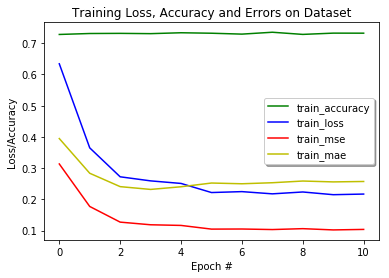

In [24]:
train(model=model, data=((x_train, y_train), (x_test[:], y_test[:])),epoch_size_frac = 1)

In [25]:
# Combine images - from generated images
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

# Test model using test dataset
def test(model, data):
    x_test,y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print("Groud Truth values: ",y_test.shape)
    print(y_test)
    print('-'*40)
    print("Predicted values: ",y_pred.shape)
    print(y_pred)
    pred = np.argmax(y_pred, axis=1)
    test = np.argmax(y_test, axis=1)
    #pred = y_pred.round()
    #test = y_test.round()
    accuracy = (np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
    precision = precision_score(test, pred,average='weighted')
    recall = recall_score(test, pred,average='weighted')
    f1 = f1_score(test, pred,average='weighted')
    print(" ")
    Cnn_Table = PrettyTable(['CapsNet Performance Metrics', '%'])
  
    # Add rows
    Cnn_Table.add_row(['Accuracy ',accuracy])
    Cnn_Table.add_row(['Precision',precision])
    Cnn_Table.add_row(['Recall/Sensitivity   ',recall])
    Cnn_Table.add_row(['F1_score ',f1])
    #myTable.add_row(['MLP_Confusion_Matrix',matrix])

    print(Cnn_Table)

    #Confusion Matrix
    print(" ")
    matrix = confusion_matrix(test, pred)
    print(" ")
    print('CapsNet_Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(classification_report(test, pred))
    
    # Reconstructed images
    img = combine_images(np.concatenate([x_test[:150],x_recon[:150]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print(" ")
    print('Reconstructed Images')
    print('-'*40)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()
    print(" ")
    print('-'*60)
    fig, axs = plt.subplots(2)
    fig.suptitle('Ground Truth Values Vs Predicted Values')
    axs[0].plot(y_test)
    axs[0].set_ylabel('y_test')
    axs[0].set_xlabel('X-axis')
    axs[1].plot(y_pred)
    axs[1].set_ylabel('y_pred')
    axs[1].set_xlabel('X-axis')
   
    
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
print("Model is ready to Test")

Model is ready to Test


Groud Truth values:  (1682, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
----------------------------------------
Predicted values:  (1682, 5)
[[0.7932017  0.13020341 0.39655146 0.12589355 0.1695346 ]
 [0.79075265 0.1302655  0.39757323 0.12562777 0.169521  ]
 [0.7933192  0.12973304 0.39612767 0.12543704 0.16999863]
 ...
 [0.7929045  0.13118422 0.39860845 0.12645121 0.16876246]
 [0.7929734  0.1307635  0.3975521  0.12526287 0.1695935 ]
 [0.7913253  0.1306524  0.39751488 0.12524635 0.16954622]]
 
+-----------------------------+--------------------+
| CapsNet Performance Metrics |         %          |
+-----------------------------+--------------------+
|          Accuracy           | 0.7306777645659929 |
|          Precision          | 0.5338899956311565 |
|    Recall/Sensitivity       | 0.7306777645659929 |
|          F1_score           | 0.6169721557207869 |
+-----------------------------+--------------------+
 
 
C

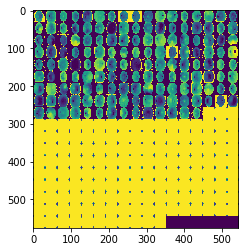

 
------------------------------------------------------------


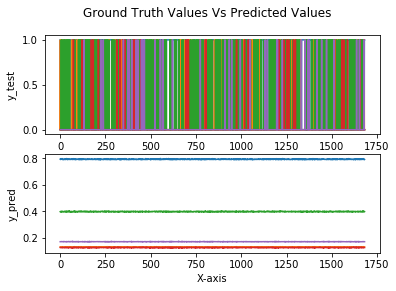

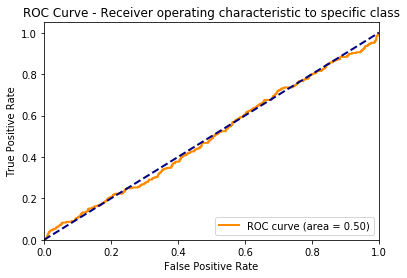

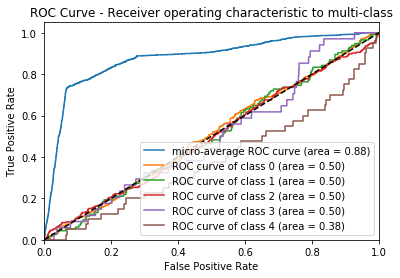

In [28]:
# Testing the CapsNet Model

#test(model=model, data=(x_test[:100], y_test[:100]))
test(model=model, data=(x_test, y_test))

In [ ]:
#del x_train, x_test, y_train, y_test
#gc.collect()